<a href="https://www.kaggle.com/code/gpreda/turkish-fake-names-clustering-using-lsh?scriptVersionId=126160781" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction


Locality sensitive hashing (LSH) is a method for quickly finding (approximate) nearest neighbors.   

The implementation by `dougian` (https://github.com/dougian/lsh) follows the approach of generating random hyperplanes to partition the dimension space in neighborhoods and uses that to hash the input space into buckets.   

To read more about LSH and this specific implementation, see https://en.wikipedia.org/wiki/Locality-sensitive_hashing#Random_projection

# Analysis preparation

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from time import time
import itertools
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

In [2]:
customers_df = pd.read_csv("/kaggle/input/fake-turkish-names-csv-format/Customers_100K_Row.csv")

In [3]:
customers_df.shape

(100000, 15)

In [4]:
customers_df.head()

,ID,NAME_,SURNAME,NAMESURNAME,GENDER,BIRTHDATE,EMAIL,TCNUMBER,TELNR,CITY,TOWN,DISTRICT,STREET,POSTALCODE,ADDRESSTEXT
0,1,Melike,ÖZİPEK,Melike ÖZİPEK,K,1970-02-13,mel_ozipek@fakeyahoo.com,42151320682,555-4182308,Gaziantep,OĞUZELİ,ÇAYBAŞI MAH.,BESİ ORG.SAN.79 CADDESİ,27900,ÇAYBAŞI MAH. BESİ ORG.SAN.79 CADDESİ 27900 O...
1,2,Nurullah,ZARA,Nurullah ZARA,E,1983-01-19,nur_zara@fakeyahoo.com,60636200182,539-1901971,Diyarbakır,SUR,CEVAT PAŞA MAH.,ÇUBUKÇU 1.ÇIKMAZ SOKAK,21200,CEVAT PAŞA MAH. ÇUBUKÇU 1.ÇIKMAZ SOKAK 21200 ...
2,3,Serap Helin,ÖZALVUÇ,Serap Helin ÖZALVUÇ,K,1974-06-29,ser_ozalvuc@fakelive.com,92707435940,536-3952903,Çanakkale,GELİBOLU,GÜNEYLİ KÖYÜ,GÜNEYLİ/AY SOKAK,17502,GÜNEYLİ KÖYÜ MAH. GÜNEYLİ/AY SOKAK 17502 GEL...
3,4,Elanur Seval,ÇETİNTÜRK,Elanur Seval ÇETİNTÜRK,K,1998-04-05,ela_cetinturk@fakelive.com,73627386710,532-1391444,Osmaniye,KADİRLİ,YENİ MAH.,187. SOKAK,80750,YENİ MAH. 187. SOKAK 80750 KADİRLİ/OSMANİYE
4,5,Elmas,OKKACI,Elmas OKKACI,K,1973-02-23,elm_okkaci@fakeoutlook.com,19155799028,552-1923716,Sakarya,ADAPAZARI,SEMERCİLER MAH.,ÖNDER SOKAK,54100,SEMERCİLER MAH. ÖNDER SOKAK 54100 ADAPAZARI/...


# LSH

## Vectorization with TF-IDF

In [5]:
customers_df["CHAR_NAMESURNAME"] = customers_df["NAMESURNAME"].apply(lambda x: " ".join([c for c in x]))
customers_df[["NAMESURNAME", "CHAR_NAMESURNAME"]].head(2)
def preprocess(text):
    return nltk.word_tokenize(text)

vectorizer = TfidfVectorizer(tokenizer = preprocess,
                            ngram_range=(1,3))

start_time = time()
vect = vectorizer.fit_transform( customers_df["CHAR_NAMESURNAME"])
end_time = time()
print(f"Total time: {round(end_time-start_time, 4)} sec.")
vocabulary = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(vocabulary)}")

Total time: 14.8394 sec.
Vocabulary size: 9630


In [6]:
from copy import copy
from itertools import combinations
import numpy as np
from pandas import DataFrame
from sklearn.metrics.pairwise import pairwise_distances


class LSH:
    def __init__(self, data):
        self.data = data
        self.model = None

    def __generate_random_vectors(self, num_vector, dim):
        return np.random.randn(dim, num_vector)

    def train(self, num_vector, seed=None):
        dim = self.data.shape[1]
        if seed is not None:
            np.random.seed(seed)

        random_vectors = self.__generate_random_vectors(num_vector, dim)
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        table = {}

        # Partition data points into bins
        bin_index_bits = (self.data.dot(random_vectors) >= 0)

        # Encode bin index bits into integers
        bin_indices = bin_index_bits.dot(powers_of_two)

        # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
        for data_index, bin_index in enumerate(bin_indices):
            if bin_index not in table:
                # If no list yet exists for this bin, assign the bin an empty list.
                table[bin_index] = []
            # Fetch the list of document ids associated with the bin and add the document id to the end.
            table[bin_index].append(data_index)

        self.model = {'bin_indices': bin_indices, 'table': table,
                      'random_vectors': random_vectors, 'num_vector': num_vector}
        return self

    def __search_nearby_bins(self, query_bin_bits, table, search_radius=2, initial_candidates=set()):
        num_vector = self.model['num_vector']
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        # Allow the user to provide an initial set of candidates.
        candidate_set = copy(initial_candidates)

        for different_bits in combinations(range(num_vector), search_radius):
            alternate_bits = copy(query_bin_bits)
            for i in different_bits:
                alternate_bits[i] = 1 if alternate_bits[i] == 0 else 0

            # Convert the new bit vector to an integer index
            nearby_bin = alternate_bits.dot(powers_of_two)

            # Fetch the list of documents belonging to the bin indexed by the new bit vector.
            # Then add those documents to candidate_set
            if nearby_bin in table:
                candidate_set.update(table[nearby_bin])

        return candidate_set

    def query(self, query_vec, k, max_search_radius, initial_candidates=set()):

        if not self.model:
            print('Model not yet build. Exiting!')
            exit(-1)

        data = self.data
        table = self.model['table']
        random_vectors = self.model['random_vectors']

        bin_index_bits = (query_vec.dot(random_vectors) >= 0).flatten()

        candidate_set = set()
        # Search nearby bins and collect candidates
        for search_radius in range(max_search_radius + 1):
            candidate_set = self.__search_nearby_bins(bin_index_bits, table,
                                                      search_radius, initial_candidates=initial_candidates)
        # Sort candidates by their true distances from the query
        nearest_neighbors = DataFrame({'id': list(candidate_set)})
        candidates = data[np.array(list(candidate_set)), :]
        nearest_neighbors['distance'] = pairwise_distances(candidates, query_vec, metric='cosine').flatten()

        return nearest_neighbors.nsmallest(k, 'distance')


In [7]:
#assumes that data is a num_observations by num_features numpy matrix
lsh_model = LSH(vect)
# num of random vectors is the power of two to generate bins
num_of_random_vectors = 7
lsh_model.train(num_of_random_vectors)

Let's explore the model.

In [8]:
for item in lsh_model.model.items():
    print(f"{item[0]}: {type(item[1])}  {len(item[1]) if isinstance(item[1], (list, dict, np.ndarray)) else item[1]}")

bin_indices: <class 'numpy.ndarray'>  100000
table: <class 'dict'>  128
random_vectors: <class 'numpy.ndarray'>  9630
num_vector: <class 'int'>  7


### bin_indices

`bin_indices` has the dimmension of our corpus of documents (100K). They represent the indices of the bins. The numbers are from 0 to `pow(2, num_of_random_vectors)`. Bin indices gives the indices of bin assigned for every item in the initial collection.

In [9]:
print(f"Length of bin indices: {len(lsh_model.model['bin_indices'])}")
print(f"Min value in the bin indices: {max(lsh_model.model['bin_indices'])}")
print(f"Max value in the bin indices: {max(lsh_model.model['bin_indices'])}")

Length of bin indices: 100000
Min value in the bin indices: 127
Max value in the bin indices: 127


### table

`table` has dimmension of number of bins. For each of the bins, we have the indices in the original set of documents (from 0 to 99_999)). Each item in table has the dimmension of the current bin.

In [10]:
print(f"Min dimmension of an index table: {min([len(lsh_model.model['table'][i]) for i in range(128)])}")
print(f"Max dimmension of an index table: {max([len(lsh_model.model['table'][i]) for i in range(128)])}")
print(f"Mean dimmension of an index table: {np.mean([len(lsh_model.model['table'][i]) for i in range(128)])}")

print(f"Min index in a table: {min([min(lsh_model.model['table'][i]) for i in range(128)])}")
print(f"Max index in a table: {max([max(lsh_model.model['table'][i]) for i in range(128)])}")


Min dimmension of an index table: 318
Max dimmension of an index table: 1409
Mean dimmension of an index table: 781.25
Min index in a table: 0
Max index in a table: 99999


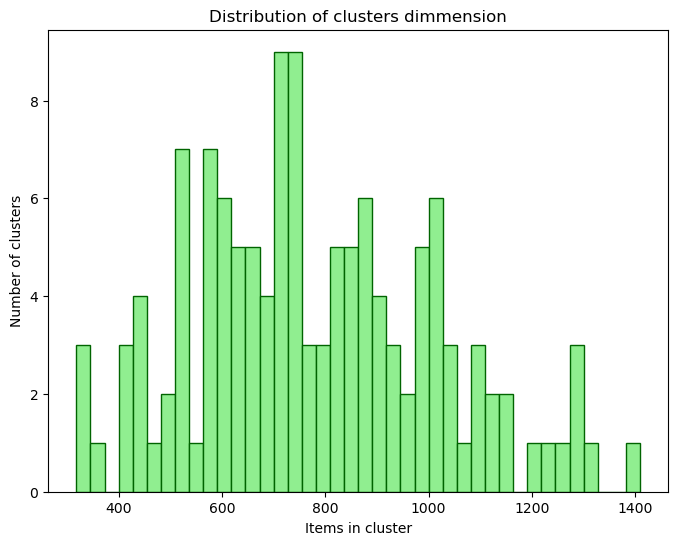

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(1,1, figsize=(8,6))
plt.hist(x=[len(lsh_model.model['table'][i]) for i in range(128)],bins=40, color='lightgreen', edgecolor="darkgreen")
plt.title("Distribution of clusters dimmension")
plt.xlabel("Items in cluster")
plt.ylabel("Number of clusters")
plt.show()

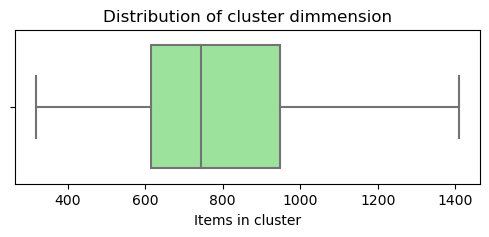

In [12]:
f, ax = plt.subplots(1,1, figsize=(6,2))
sns.boxplot(x=[len(lsh_model.model['table'][i]) for i in range(128)], color="lightgreen")
plt.title("Distribution of cluster dimmension")
plt.xlabel("Items in cluster")
plt.show()

### random_vectors

Dimmension of random vectors is the dimmension of the vocabulary.  
Each index table has dimmension equal with `num_of_random_vectors`.

In [13]:
random_vector_list = len(lsh_model.model['random_vectors'])
print(f"Dimmension of random_vector list: {random_vector_list}")

print(f"Min dimmension of an index table: {min([len(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")
print(f"Max dimmension of an index table: {max([len(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")

print(f"Min value in tables: {min([min(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")
print(f"Max value in tables: {max([max(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")
print(f"Mean value in tables: {np.mean([np.mean(lsh_model.model['random_vectors'][i]) for i in range(random_vector_list)])}")


Dimmension of random_vector list: 9630
Min dimmension of an index table: 7
Max dimmension of an index table: 7
Min value in tables: -4.022485961543023
Max value in tables: 3.889996412820842
Mean value in tables: -0.0009004222471537376


Let's also look to an index table.

In [14]:
print(lsh_model.model['random_vectors'][0])

[-0.29012674 -0.12076405 -0.48319541  0.01189605  0.10486348  1.34974118
 -0.57882557]


### num_vector

This is our preset value of vectors, i.e. value of parameter with which we initialized LSH model.

## Profiling

Let's calculate how fast we retrieve, for all the items in the original corpus, the nearest neighbors (i.e. the potential matches).
We start by searching in only 2 vectors, then we increase.

In [15]:
blocks_number = 100
block_size = int(customers_df.shape[0] / blocks_number)
print(f"Blocks: {blocks_number}\nBlock size: {block_size}")

Blocks: 100
Block size: 1000


### Dependence of max_search_radius

In [16]:
start_time = time()
#for i in range(0,blocks_number):
for i in range(0,1): #we compute for now only 1 block, we just want to see diff. in search time for various max search radius
    
    index_i = i * block_size
    if i == blocks_number - 1:
        vect_i = vect[index_i:]
    else:   
        vect_i = vect[index_i:index_i+block_size]
    for max_search_radius in [2, 3, 4, 5, 6, 7]:
        s_time = time()
        temp_distances = [lsh_model.query(query_vec=vect_i[i,:], k=5, max_search_radius=max_search_radius) for i in range(block_size)]
        e_time = time()
        print(f"Time segment [{i}/{blocks_number}], max search radius {max_search_radius} : {round(e_time-s_time, 4)} sec.")
end_time = time()
print(f"Total time: {round(end_time-start_time, 4)} sec.")

Time segment [0/100], max search radius 2 : 33.3445 sec.
Time segment [0/100], max search radius 3 : 53.6146 sec.
Time segment [0/100], max search radius 4 : 58.5698 sec.
Time segment [0/100], max search radius 5 : 48.1337 sec.
Time segment [0/100], max search radius 6 : 33.266 sec.
Time segment [0/100], max search radius 7 : 26.6092 sec.
Total time: 253.5417 sec.


### Dependence on k

In [17]:
start_time = time()
for i in range(0,1): #we compute for now only 1 block, we just want to see diff. in search time for various k
    
    index_i = i * block_size
    if i == blocks_number - 1:
        vect_i = vect[index_i:]
    else:   
        vect_i = vect[index_i:index_i+block_size]
    for k in [2, 5, 10, 25, 50, 100, 1_000, 10_000, 100_000]:
        s_time = time()
        temp_distances = [lsh_model.query(query_vec=vect_i[i,:], k=k, max_search_radius=7) for i in range(block_size)]
        e_time = time()
        print(f"Time segment [{i}/{blocks_number}], k {k} : {round(e_time-s_time, 4)} sec.")
end_time = time()
print(f"Total time: {round(end_time-start_time, 4)} sec.")

Time segment [0/100], k 2 : 26.5182 sec.
Time segment [0/100], k 5 : 26.8906 sec.
Time segment [0/100], k 10 : 27.0571 sec.
Time segment [0/100], k 25 : 26.0695 sec.
Time segment [0/100], k 50 : 26.0408 sec.
Time segment [0/100], k 100 : 25.9656 sec.
Time segment [0/100], k 1000 : 26.295 sec.
Time segment [0/100], k 10000 : 25.7138 sec.
Time segment [0/100], k 100000 : 26.3447 sec.
Total time: 236.8985 sec.


## Consistence

In [18]:
for k in [5, 10, 25, 50, 100, 10_000, 25_000, 50_000, 100_000]:
    data_df = lsh_model.query(query_vec=vect_i[1,:], k=k, max_search_radius=7)
    data_df = data_df.sort_values(by="distance", ascending=False)
    print(f"k: {k}")
    print(data_df.head())

k: 5
        id  distance
469  27912  0.858965
432  68786  0.856055
304  52070  0.842555
125  72039  0.832924
727  44995  0.775715
k: 10
        id  distance
82   18658  0.874627
591  83555  0.868601
183  23040  0.867781
368  62465  0.866074
157  10676  0.861541
k: 25
        id  distance
96   37117  0.889076
606  13964  0.888575
182  61949  0.887243
305   7016  0.886568
209  27242  0.886342
k: 50
        id  distance
341  62405  0.910083
62   49336  0.908337
48   92303  0.907563
633  48858  0.907413
108  61736  0.906724
k: 100
        id  distance
293  76622  0.925317
610   9878  0.925269
239  25268  0.925015
523  93625  0.924984
261  21231  0.924804
k: 10000
        id  distance
741  45033  1.000000
95   10489  0.997205
426  19619  0.997042
436  76984  0.997023
88   10477  0.995337
k: 25000
        id  distance
741  45033  1.000000
95   10489  0.997205
426  19619  0.997042
436  76984  0.997023
88   10477  0.995337
k: 50000
        id  distance
741  45033  1.000000
95   10489  0.99720

In [19]:
for max_search_radius in [1, 2, 3, 4, 5, 6, 7]:
    data_df = lsh_model.query(query_vec=vect_i[1,:], k=100_000, max_search_radius=max_search_radius)
    data_df = data_df.sort_values(by="distance", ascending=False)
    print(f"max_search_radius: {max_search_radius}")
    print(data_df.head())

max_search_radius: 1
         id  distance
991   38423  1.000000
4949  30548  1.000000
1042  38702  0.997472
1060   6058  0.997205
2540  80829  0.997048
max_search_radius: 2
          id  distance
11148  55388       1.0
5005   42702       1.0
3058   71422       1.0
2024   36495       1.0
13463  60138       1.0
max_search_radius: 3
          id  distance
11277  42023       1.0
4223   15564       1.0
5788   21588       1.0
22483  83943       1.0
12327  46074       1.0
max_search_radius: 4
          id  distance
198      697       1.0
5694   20550       1.0
11347  40819       1.0
19304  69173       1.0
12242  43908       1.0
max_search_radius: 5
          id  distance
16876  98303       1.0
15847  63555       1.0
11331  87335       1.0
9575   51143       1.0
10149  19526       1.0
max_search_radius: 6
         id  distance
3364  84444       1.0
4039  88658       1.0
2204  12057       1.0
2324  12744       1.0
3301  18467       1.0
max_search_radius: 7
        id  distance
741  45033  1.00